In [74]:
from useful_functions import *
import warnings
warnings.filterwarnings('ignore')
from category_encoders import LeaveOneOutEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette = "Dark2")
my_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
  (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
pd.set_option('display.max_columns', None)
from itertools import chain, combinations

In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import tensorflow as tensorflow
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

### **5 Leave-one-out Encoding**
In order not to split the data into three different sets, we will use a leave-one-out encoding. This type of encoding calculates the target response mean for each variable **excluding** the current observation to reduce the effect of outliers. It further adds random noise to the target response to avoid overfitting.

In [3]:
df = pd.read_csv("df_processed.csv")
df

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,0.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,S-Holstein,2011-02-16,0.0,4,2012-04-02_825,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,0,9,4,5,2,7,3,6,0,9,0,9,2,7,3,6,2,7,0,9,2,7
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,1,8,4,5,2,7,3,6,1,8,1,8,2,7,3,6,2,7,1,8,2,7
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63,35,6,3,4,5,28,2,17,18,79.90,1,79.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Bburg,2013-04-28,NaN,4,2013-04-28_91922,43,0,6,3,4,5,28,2,17,18,59.90,2,119.8,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2


In [5]:
low_cardinality_cat_cols = ["size","item_color","user_title","user_state"]
high_cardinality_cat_cols = ["item_id","brand_id","user_id"]
cat_cols = low_cardinality_cat_cols + high_cardinality_cat_cols

In [6]:
# size of the known dataset
k = max(df["order_item_id"])-1

# Get the validation set
df_valid = df.iloc[k:, :]
# df_train,df_test = df.loc[:k][df.loc[:k,"order_month"] != 3],df.loc[:k][df.loc[:k,"order_month"] == 3]


In [7]:
# Get list of the months to train, remove months on which to test
months_to_train = list(range(1,13))
months_to_train.remove(3)
# Split into train and test. "~" in front of a variable means "not"
df_train = df.loc[:k][df.loc[:k,"order_month"].isin(months_to_train)]
df_test = df.loc[:k][~df.loc[:k,"order_month"].isin(months_to_train)]

# Drop unnecessary columns
columns_to_drop = ["order_date", "delivery_date", "user_dob", "user_reg_date", "order_id","order_item_id"]
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)
df_valid.drop(columns_to_drop, axis=1, inplace=True)

Since we are no longer using one-hot encoding, we will rework our models not to include the one-hot encoding.

In [88]:
# Xgboost classifier to train the model and use ROC as the metric
def xgboost_classifier(df_train, df_test):
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    
    model = XGBClassifier(max_depth=7, n_estimators=50, learning_rate=0.1,
                            n_jobs=-1, random_state=42)
    model.fit(X_train, Y_train, eval_metric='auc', eval_set=[(X_test, Y_test)],early_stopping_rounds = 20,verbose = 0)
    Y_pred = model.predict(X_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("Xgboost AUC on test set:", auc)
    return model,auc

In [9]:
# Catboost classifier to train the model and use ROC as the metric
def catboost_classifier(df_train, df_test,cat_cols):
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=10,
                            loss_function='Logloss', eval_metric='AUC',
                            random_seed=42)
    pool_train = Pool(X_train, Y_train,cat_features = cat_cols)

    pool_test = Pool(X_test, Y_test,cat_features = cat_cols)
    

    
    model.fit(pool_train, eval_set=pool_test, use_best_model=True, verbose=False)
    Y_pred = model.predict(pool_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("Catboost AUC on test set:", auc)
    return model,auc

In [10]:
# LightGBM
def lightgbm(df_train,df_test):
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    
    model = LGBMClassifier(boosting_type='gbdt')
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("LGBM AUC on test set: ", auc)
    return model,auc

In [11]:
def neural_network(df_train,df_test,epochs):
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    auc = tensorflow.keras.metrics.AUC()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    
    results = model.fit(X_train, Y_train, epochs=epochs, batch_size=256, verbose=1,validation_data=(X_test, Y_test))
    Y_pred = model.predict(X_test)
    auc_1 = roc_auc_score(Y_test, Y_pred)
    print("ROC on test set:", auc_1)
    return model,auc_1, results.history[auc.name], results.history['val_'+auc.name]

In [85]:
# Encode categorical variables using leave one out encoding
def encode_categorical_columns(df_train,df_test,columns,sig):
    encoder = LeaveOneOutEncoder(cols=columns, return_df=True,sigma=sig, verbose=True)
    df_encode_train = encoder.fit_transform(df_train.drop(["return"],axis=1),df_train[["return"]])
    df_encode_test = encoder.transform(df_test.drop(["return"],axis=1))
    df_encode_train , df_encode_test = df_encode_train.join(df_train[["return"]]), df_encode_test.join(df_test[["return"]])
    return df_encode_train, df_encode_test, encoder

In [92]:
df_train, df_test, encoder = encode_categorical_columns(df_train,df_test,cat_cols,0.1)

In [93]:
df_train

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id,return
0,0.617373,0.548014,0.520261,0.735728,69.90,0.539592,0.487594,0.365430,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.80,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0.0
1,0.723669,0.453842,0.451558,0.443151,69.95,0.441709,0.483240,0.518341,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.80,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3,1.0
2,0.619180,0.345758,0.486067,0.640610,69.95,0.446865,0.491034,0.455364,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.80,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3,1.0
3,0.396502,0.490705,0.393220,0.658324,39.90,0.510317,0.404429,0.537943,4,52,89,0,4,4,4,2,6,14,14,39.90,1,39.90,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0.0
4,0.577156,0.550700,0.627206,0.717851,29.90,0.000000,0.461461,0.372865,4,48,411,0,4,4,4,2,6,14,14,83.23,3,249.70,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412004,0.579990,0.540648,0.509167,0.595892,69.95,0.944907,0.514203,0.500607,5,32,0,3,1,2,3,28,5,9,10,41.91,5,209.55,0,5,0,5,2,3,0,5,0,5,0,5,0,5,0,5,0,5,0,5,0,5,1.0
412005,0.548777,0.560873,0.447566,0.456449,34.90,1.083667,0.520958,0.576596,5,32,0,3,1,2,3,28,5,9,10,41.91,5,209.55,3,2,3,2,2,3,3,2,3,2,1,4,1,4,3,2,1,4,1,4,1,4,1.0
412006,0.623129,0.462269,0.508073,0.472124,34.90,1.009745,0.519297,0.549838,5,32,0,3,1,2,3,28,5,9,10,41.91,5,209.55,3,2,3,2,2,3,3,2,3,2,1,4,1,4,3,2,1,4,1,4,1,4,1.0
412007,0.636949,0.447757,0.487433,0.448513,34.90,1.039730,0.521708,0.474789,5,32,0,3,1,2,3,28,5,9,10,41.91,5,209.55,3,2,3,2,1,4,3,2,3,2,1,4,1,4,3,2,1,4,1,4,1,4,1.0


In [55]:
catboost_model,catboost_auc = catboost_classifier(df_train,df_test,[])

Catboost AUC on test set: 0.6625998718859887


In [56]:
lightgbm_model,lightgbm_auc = lightgbm(df_train,df_test)

LGBM AUC on test set:  0.6650706916029628


In [57]:
xgb_model,xgb_auc = xgboost_classifier(df_train,df_test)

Xgboost AUC on test set: 0.6622517664192289


In [78]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_train,df_test,10)

Epoch 1/10
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6007 - auc_4: 0.7359 - val_loss: 0.6440 - val_auc_4: 0.6976
Epoch 2/10
1608/1608 [==============================] - 2s 1ms/step - loss: 0.5864 - auc_4: 0.7514 - val_loss: 0.6430 - val_auc_4: 0.7064
Epoch 3/10
1608/1608 [==============================] - 2s 1ms/step - loss: 0.5827 - auc_4: 0.7553 - val_loss: 0.6423 - val_auc_4: 0.7091
Epoch 4/10
1608/1608 [==============================] - 2s 1ms/step - loss: 0.5808 - auc_4: 0.7573 - val_loss: 0.6412 - val_auc_4: 0.7112
Epoch 5/10
1608/1608 [==============================] - 2s 2ms/step - loss: 0.5796 - auc_4: 0.7587 - val_loss: 0.6430 - val_auc_4: 0.7115
Epoch 6/10
1608/1608 [==============================] - 2s 1ms/step - loss: 0.5785 - auc_4: 0.7599 - val_loss: 0.6476 - val_auc_4: 0.7124
Epoch 7/10
1608/1608 [==============================] - 2s 1ms/step - loss: 0.5772 - auc_4: 0.7615 - val_loss: 0.6530 - val_auc_4: 0.7124
Epoch 8/10
1608/1608 [============

In [61]:
auc_dict_target = {"Catboost":catboost_auc,"Xgboost":xgb_auc,"Lightgbm":lightgbm_auc,"Neural_Network":neural_network_auc}
model_results_target = pd.DataFrame(auc_dict_target,index=["AUC_encoding"])
model_results_target.sort_values(by="AUC_encoding",ascending=False,inplace=True,axis=1)
model_results_target = round(model_results_target.transpose(),3) 
model_results_target  

,AUC_encoding
Neural_Network,0.716
Lightgbm,0.665
Catboost,0.663
Xgboost,0.662


We can see that the tree-based models do not perform as good as the neural network model and are not affected by the encoding as their performances did not change. Overall using the **Leave-One-Out Encoding**, the neural network model performs better than before and reached a relatively good AUC score of **0.72**. From now on we are only going to focus on the neural network model.

In [ ]:
# # ANOVA feature selection for numeric input and categorical output
# from sklearn.datasets import make_classification
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# fs = SelectKBest(score_func=f_classif, k=35)
# # apply feature selection
# X_selected = fs.fit_transform(df_train.drop(["return"],axis=1),df_train["return"])

# X_selected
# test_features = fs.get_feature_names_out(df_train.drop(["return"],axis=1).columns)
# test_features = np.append( test_features, ["return"])
# test_features

# neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_train[test_features],df_test[test_features],10)

## **6 Further Feature Engineering**

### **6.1 Days till Birthday**
Customer behavior and therefore their return rate might be influenced if a customer has a birthday in the near future, or if he already had one shortly before placing an order or getting the items delivered to him/her. Therefore, we will add a feature that calculates the days till the customer's birthday.

In [127]:
df['user_dob'] = pd.to_datetime(df.user_dob, format='%Y-%m-%d')
df['order_date'] = pd.to_datetime(df.order_date, format='%Y-%m-%d')
df['delivery_date'] = pd.to_datetime(df.delivery_date, format='%Y-%m-%d')
# Get days until birthday
df['days_till_bday_order_date'] = df['user_dob'].dt.dayofyear - df['order_date'].dt.dayofyear
df['days_till_bday_delivery_date'] = df['user_dob'].dt.dayofyear - df['delivery_date'].dt.dayofyear
df['days_till_bday_order_date'].fillna(500,inplace=True)
df['days_till_bday_delivery_date'].fillna(500,inplace=True)

In [128]:
# Create labels for days till birthday
days_bin = [-1000, -7, -3, -1, 0, 1, 3 ,7 ,1000]
# create labels for days till birthday including negative values
labels_birthday = ['<(-7)', '(-7),(-3)', '(-3),(-1)', '(-1)', '0', '1,3', '3,7', '>7']
df["days_till_bday_order_date_bin"] = pd.cut(df["days_till_bday_order_date"],bins=days_bin,labels=labels_birthday,right=False)
df["days_till_bday_delivery_date_bin"] = pd.cut(df["days_till_bday_delivery_date"],bins=days_bin,labels=labels_birthday,right=False)

In [129]:
df_train = df.loc[:k][df.loc[:k,"order_month"].isin(months_to_train)]
df_test = df.loc[:k][~df.loc[:k,"order_month"].isin(months_to_train)]
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)

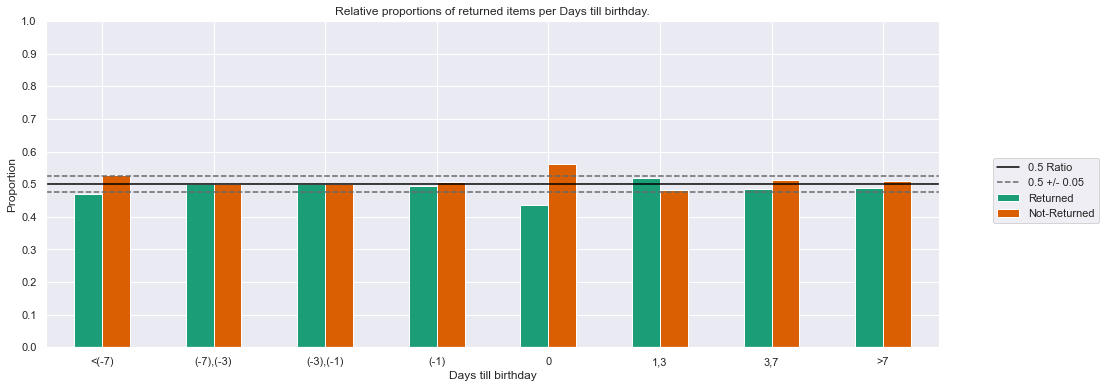

In [130]:
days_till_bday_order_date_bin = get_return_rate(df.iloc[0:k], 'days_till_bday_order_date_bin', False)
create_barplot(days_till_bday_order_date_bin, (16,6),0, "Days till birthday",my_colors)

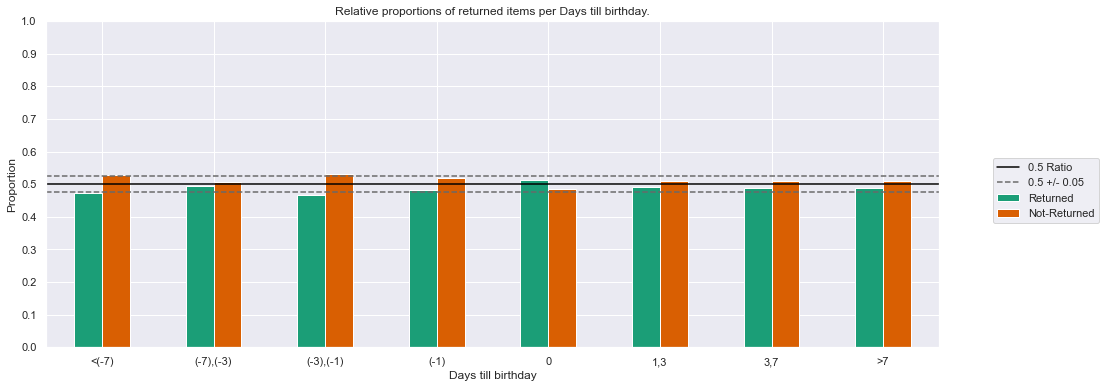

In [131]:
days_till_bday_delivery_date_bin = get_return_rate(df.iloc[0:k], 'days_till_bday_delivery_date_bin',False)
create_barplot(days_till_bday_delivery_date_bin, (16,6),0, "Days till birthday",my_colors)

Judging from both bar plots the days till the customer's birthday is not a particularly significant feature. Only the customers who have a birthday on the day they placed the order seem to have a significant impact on the return rate.

In [77]:
def get_return_rate(df:dict, column:str, sort:bool) -> dict:
    return_rate = df[['return', column]].groupby([column]).count()
    return_rate.rename(columns={'return': 'count'}, inplace=True)
    return_rate["Returned"] = df[['return', column]].groupby([column]).mean()
    return_rate["Not-Returned"] = abs(return_rate["Returned"] - 1)

    if sort:
        return_rate.sort_values(by=['count'], ascending=False, inplace=True)
    return_rate.drop(['count'], axis=1, inplace=True)
    return return_rate

def create_barplot(feature_return_rate :dict, x_y:tuple, r:int , name:str, my_colors) -> object: 
    import numpy as np
    import matplotlib.pyplot as plt
    # plot = plt.figure()
    plot = feature_return_rate.plot(kind='bar', stacked = False, figsize = x_y, title = "Relative proportions of returned items per %s." % name,
                xlabel = name, ylabel = "Proportion", yticks = np.arange(0, 1.1, step = 0.1), color = my_colors)

    plt.xticks(rotation=r)
    plot.axhline(y = .5, color = "black", label = "0.5 Ratio")
    plot.axhline(y = 0.525, color = "dimgrey", linestyle = "--")
    plot.axhline(y = 0.475, color = "dimgrey", linestyle = "--", label = "0.5 +/- 0.05")
    plt.legend(loc = "center", bbox_to_anchor = (0.87, 0.23,  0.5, 0.5))
    plt.show()

In [94]:
test = ["return", "days_till_bday_order_date_bin", "days_till_bday_delivery_date_bin"]
test_col = [test[1], test[2]]
df_train_encoded, df_test_encoded, encoder = encode_categorical_columns(df_train[test],df_test[test],test_col,0.1)
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_train_encoded,df_test_encoded,3)

Epoch 1/3
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6925 - auc_5: 0.4983 - val_loss: 0.6960 - val_auc_5: 0.4966: 0s - loss: 0.6926
Epoch 2/3
1608/1608 [==============================] - 2s 1ms/step - loss: 0.6923 - auc_5: 0.5009 - val_loss: 0.6955 - val_auc_5: 0.4960
Epoch 3/3
1608/1608 [==============================] - 2s 2ms/step - loss: 0.6922 - auc_5: 0.5013 - val_loss: 0.6952 - val_auc_5: 0.4965
ROC on test set: 0.4965921495441048


The results from the model confirm that the days till the customer's birthday are is a particularly significant feature due to the low AUC score. For this reason, we will not add this feature to the model.

In [145]:
# drop birthday features
birthday_features = ["days_till_bday_order_date", "days_till_bday_order_date_bin", "days_till_bday_delivery_date_bin","days_till_bday_delivery_date"]
df.drop(birthday_features, axis=1, inplace=True)

### **6.2 Package Features**

In [147]:
df["package_id"] = df["delivery_date"].astype(str) + "_" + df["user_id"].astype(str)
df

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id,package_id
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,0.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,2012-04-03_794
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3,2012-04-03_794
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3,2012-04-03_794
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,2012-04-06_808
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,S-Holstein,2011-02-16,0.0,4,2012-04-02_825,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3,2012-04-06_825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,0,9,4,5,2,7,3,6,0,9,0,9,2,7,3,6,2,7,0,9,2,7,2013-05-03_91920
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,1,8,4,5,2,7,3,6,1,8,1,8,2,7,3,6,2,7,1,8,2,7,2013-05-03_91920
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63,35,6,3,4,5,28,2,17,18,79.90,1,79.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,2013-05-02_85095
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Bburg,2013-04-28,NaN,4,2013-04-28_91922,43,0,6,3,4,5,28,2,17,18,59.90,2,119.8,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2,2013-05-02_91922


In [153]:
# Get number of items per package
df_group = df[["package_id","delivery_date"]].groupby("package_id").count().rename(columns={"delivery_date":"package_item_count"})
df = pd.merge(df, df_group, on = "package_id", how = "left")

# Get total price per package
df_group = df[["package_id","item_price"]].groupby("package_id").sum().rename(columns={"item_price":"package_sum"})
df = pd.merge(df, df_group, on = "package_id", how = "left")

# Get average item price per package
df["average_item_price_package"] = df["package_sum"]/df["package_item_count"]
df["average_item_price_package"] = round(df["average_item_price_package"],2)

# Ratio of package item count to order item count   
df["package_item_count_ratio"] = df["package_item_count"]/df["order_item_count"]

,user_id
0,794
1,794
2,794
3,808
4,825
...,...
531165,91920
531166,91920
531167,85095
531168,91922


In [195]:
# Get Package_id per order id
df_group = df[["order_id","package_id"]].groupby(["order_id","package_id"]).count()
df_group

Empty DataFrame
Columns: []
Index: [(2012-04-01_1010, 2012-04-05_1010), (2012-04-01_1110, 2012-04-04_1110), (2012-04-01_1110, 2012-04-05_1110), (2012-04-01_1110, 2012-05-10_1110), (2012-04-01_1112, 2012-04-13_1112), (2012-04-01_1114, 2012-04-04_1114), (2012-04-01_1114, 2012-04-05_1114), (2012-04-01_1114, 2012-06-14_1114), (2012-04-01_1115, 2012-04-04_1115), (2012-04-01_1115, 2012-04-09_1115), (2012-04-01_1115, 2012-04-26_1115), (2012-04-01_1116, 2012-04-03_1116), (2012-04-01_1119, 2012-04-05_1119), (2012-04-01_1121, 2012-04-04_1121), (2012-04-01_1121, 2012-05-02_1121), (2012-04-01_1122, 2012-04-03_1122), (2012-04-01_1123, 2012-04-03_1123), (2012-04-01_1123, 2012-04-09_1123), (2012-04-01_1123, 2012-05-11_1123), (2012-04-01_1123, 2012-05-22_1123), (2012-04-01_1128, 2012-04-04_1128), (2012-04-01_1128, 2012-04-09_1128), (2012-04-01_1128, 2012-04-19_1128), (2012-04-01_1131, 2012-04-03_1131), (2012-04-01_1133, 2012-04-03_1133), (2012-04-01_1133, 2012-04-05_1133), (2012-04-01_1133, 2012-05-14_1133), (2012-04-01_1134, 2012-04-03_1134), (2012-04-01_1134, 2012-05-21_1134), (2012-04-01_1135, 2012-04-04_1135), (2012-04-01_1135, 2012-04-05_1135), (2012-04-01_1135, 2012-04-09_1135), (2012-04-01_1135, 2012-05-11_1135), (2012-04-01_1139, 2012-05-16_1139), (2012-04-01_1141, 2012-04-05_1141), (2012-04-01_1145, 2012-04-24_1145), (2012-04-01_1147, 2012-04-03_1147), (2012-04-01_1147, 2012-04-09_1147), (2012-04-01_1147, 2012-05-11_1147), (2012-04-01_1147, 2012-06-14_1147), (2012-04-01_1150, 2012-04-03_1150), (2012-04-01_1154, 2012-04-04_1154), (2012-04-01_1156, 2012-04-03_1156), (2012-04-01_1159, 2012-04-03_1159), (2012-04-01_1159, 2012-04-05_1159), (2012-04-01_1159, 2012-04-09_1159), (2012-04-01_1162, 2012-04-03_1162), (2012-04-01_1162, 2012-04-13_1162), (2012-04-01_1162, 2012-04-27_1162), (2012-04-01_1163, 2012-04-03_1163), (2012-04-01_1163, 2012-04-09_1163), (2012-04-01_1165, 2012-04-03_1165), (2012-04-01_1171, 2012-04-05_1171), (2012-04-01_1173, 2012-04-03_1173), (2012-04-01_1177, 2012-04-05_1177), (2012-04-01_1177, 2012-04-16_1177), (2012-04-01_1181, 2012-04-03_1181), (2012-04-01_1183, 2012-04-03_1183), (2012-04-01_1183, 2012-05-10_1183), (2012-04-01_1185, 2012-04-04_1185), (2012-04-01_1185, 2012-04-09_1185), (2012-04-01_1185, 2012-05-11_1185), (2012-04-01_1185, 2012-05-21_1185), (2012-04-01_1189, 2012-04-03_1189), (2012-04-01_1189, 2012-04-05_1189), (2012-04-01_1189, 2012-04-24_1189), (2012-04-01_1190, 2012-04-04_1190), (2012-04-01_1190, 2012-04-05_1190), (2012-04-01_1191, 2012-04-04_1191), (2012-04-01_1193, 2012-04-03_1193), (2012-04-01_1195, 2012-04-03_1195), (2012-04-01_1195, 2012-04-05_1195), (2012-04-01_1195, 2012-04-24_1195), (2012-04-01_1195, 2012-04-27_1195), (2012-04-01_1197, 2012-04-04_1197), (2012-04-01_1197, 2012-04-05_1197), (2012-04-01_1197, 2012-04-24_1197), (2012-04-01_1197, 2012-05-21_1197), (2012-04-01_1198, 2012-04-03_1198), (2012-04-01_1199, 2012-04-03_1199), (2012-04-01_1199, 2012-04-05_1199), (2012-04-01_1200, 2012-04-03_1200), (2012-04-01_1200, 2012-04-13_1200), (2012-04-01_1202, 2012-04-03_1202), (2012-04-01_1204, 2012-04-09_1204), (2012-04-01_1205, 2012-04-04_1205), (2012-04-01_1205, 2012-04-24_1205), (2012-04-01_1206, 2012-04-03_1206), (2012-04-01_1206, 2012-04-05_1206), (2012-04-01_1207, 2012-04-03_1207), (2012-04-01_1212, 2012-04-05_1212), (2012-04-01_1212, 2012-04-24_1212), (2012-04-01_1213, 2012-04-04_1213), (2012-04-01_1213, 2012-04-24_1213), (2012-04-01_1214, 2012-04-03_1214), (2012-04-01_1217, 2012-04-04_1217), (2012-04-01_1218, 2012-04-03_1218), (2012-04-01_1218, 2012-04-09_1218), (2012-04-01_1219, 2012-04-03_1219), (2012-04-01_1219, 2012-04-09_1219), ...]

[242654 rows x 0 columns]

In [196]:
# Get number of packages per order id
df_group = df[["order_id","package_id"]].drop_duplicates()
df_group = df_group.groupby("order_id").agg({"package_id":"number_of_packages"})
df_group

,package_id
order_id,
2012-04-01_1010,1
2012-04-01_1110,3
2012-04-01_1112,1
2012-04-01_1114,3
2012-04-01_1115,3
...,...
2013-04-30_91904,3
2013-04-30_934,1
2013-04-30_9687,3
